# Evaluation Data Overview

In [1]:
from pathlib import Path

In [2]:
OVERWRITE_LATEX_OUTPUT = False

In [3]:
PATH_LATEX_TABLE_OUTPUT = Path(f"../thesis/from_python/tables/experiments/common/")
PATH_LATEX_PLOT_OUTPUT = Path(f"../thesis/from_python/figures/experiments/common/")
PATH_LATEX_TABLE_OUTPUT.mkdir(exist_ok=True, parents=True)
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

### Generic 3-way Venn Diagram

In [4]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from evaluation.plotting import set_size

#plt.style.use("../thesis.mplstyle")

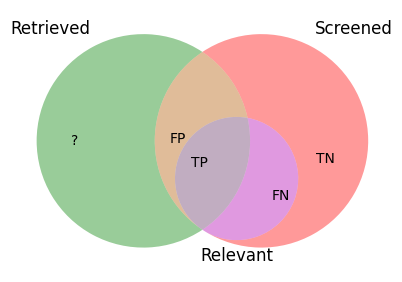

In [5]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

venn = venn3(
    subsets=(1, 0.75, 0.25, 0, 0, 0.25, 0.25),
    set_labels=("Retrieved", "Screened", "Relevant"),
    set_colors=("g", "r", "b"),
    ax=ax,
)
venn.get_label_by_id("100").set_text("?")
venn.get_label_by_id("010").set_text("TN")
venn.get_label_by_id("110").set_text("FP")
venn.get_label_by_id("111").set_text("TP")
venn.get_label_by_id("011").set_text("FN")

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "venn3_generic.pdf", bbox_inches="tight")

### Screened Data Parsing

In [6]:
import pandas as pd

In [7]:
df_es = pd.read_csv("../data/screening/esophagus/ris_with_matched_ids.csv")

In [8]:
df_hl = pd.read_csv("../data/screening/hodgkin_lymphoma/ris_with_matched_ids.csv")

In [9]:
df_hl_r = pd.read_csv(
    "../data/screening/hodgkin_lymphoma_retro/ris_with_matched_ids.csv"
)

### Retrieved Data Parsing

In [10]:
from evaluation.matching import (
    check_for_matches_in_screened,
    remove_non_null_duplicates,
)
from evaluation.metrics import remove_last_cline_from_tex_table

In [11]:
df_r_es = pd.read_parquet("../data/screening/esophagus/retrieved_evidence.parquet")
df_r_es = check_for_matches_in_screened(df_r_es, df_es)
df_r_es = remove_non_null_duplicates(df_r_es)

In [12]:
df_r_hl = pd.read_parquet(
    "../data/screening/hodgkin_lymphoma/retrieved_evidence.parquet"
)
df_r_hl = check_for_matches_in_screened(df_r_hl, df_hl)
df_r_hl = remove_non_null_duplicates(df_r_hl)

In [14]:
#df_r_hl_r = pd.read_parquet(
#    "../data/screening/hodgkin_lymphoma_retro/retrieved_evidence.parquet"
#)
#df_r_hl_r = check_for_matches_in_screened(df_r_hl_r, df_hl_r)
#df_r_hl_r = remove_non_null_duplicates(df_r_hl_r)

In [16]:
df_query = pd.concat(
    [df_r_es, df_r_hl], keys=["EC", "HL"]
).query("source != 'Trialstreamer'")
df_query["is_rct_pt_bl"] = df_query["is_rct_pt"] == True

In [19]:
overview_retrieved = (
    df_query.groupby(level=0)
    .value_counts(["is_rct_pt_bl", "source"])
    .to_frame("Count")
    .stack()
    .unstack(0)
    .rename(index={False: "Other", True: "RCTs"}, level=1)
    .reset_index(level=2, drop=True)
    .rename_axis(index={"source": "Source", "is_rct_pt_bl": "Type"})
    .fillna(0)
    .astype(int)
)
overview_retrieved = pd.concat([overview_retrieved], keys=["Evidence"], names=[""])
overview_retrieved.loc["Evidence", "Pubmed", ""] = (
    overview_retrieved.loc[("Evidence", "Pubmed"), :].sum().values
)
overview_retrieved.loc["Evidence", "", ""] = (
    overview_retrieved.drop(index="", level=2).sum().values
)
overview_retrieved.loc["SR Start", "", ""] = [
    "{" + date + "}" for date in ["09/01/2019", "01/01/2019"]
]
overview_retrieved.loc["SR End", "", ""] = [
    "{" + date + "}" for date in ["03/04/2022", "06/01/2023"]
]
overview_retrieved.loc["CUIs", "", ""] = [
    "{\makecell{" + r"\\".join(["C0014859", "C1332166", "C5400195"]) + "}}",
    "{\makecell{" + r"\\".join(["C0019829", "C1266193"]) + "}}",
    #"{\makecell{" + r"\\".join(["C0019829", "C1266193"]) + "}}",
]
overview_retrieved = (
    overview_retrieved.reindex(["SR Start", "SR End", "CUIs", "Evidence"], level=0)
    .reindex(["", "Pubmed", "ClinicalTrials", "Civic"], level=1)
    .reindex(["", "RCTs", "Other"], level=2)
)

# rename other to unknown
index_mapping = {
    ("Evidence", "ClinicalTrials", "Other"): (
        "Evidence",
        "ClinicalTrials",
        "Unknown",
    ),
    ("Evidence", "Civic", "Other"): (
        "Evidence",
        "Civic",
        "Unknown",
    ),
}
idx = overview_retrieved.index.to_series().map(lambda x: index_mapping.get(x, x))
overview_retrieved.index = pd.MultiIndex.from_tuples(
    idx, names=[None, "Source", "Type"]
)

overview_retrieved = overview_retrieved[["HL", "EC"]].drop(
    index=[
        ("Evidence", "ClinicalTrials", "RCTs"),
        ("Evidence", "Civic", "RCTs"),
    ]
)

overview_retrieved

/tmp/ipykernel_1358450/4157465210.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_retrieved.loc[("Evidence", "Pubmed"), :].sum().values


HL  \
         Source         Type                                       
SR Start                                            {01/01/2019}   
SR End                                              {06/01/2023}   
CUIs                             {\makecell{C0019829\\C1266193}}   
Evidence                                                     389   
         Pubmed                                              251   
                        RCTs                                  87   
                        Other                                164   
         ClinicalTrials Unknown                              138   
         Civic          Unknown                                0   

                                                                        EC  
         Source         Type                                                
SR Start                                                      {09/01/2019}  
SR End                                                        {03/04/2022}  
CUIs                             {\makecell{C0014859\\C1332166\\C5400195}}  
Evidence                                                               368  
         Pubmed                                                        326  
                        RCTs                                           210  
                        Other                                          116  
         ClinicalTrials Unknown                                         40  
         Civic          Unknown                                          2

In [16]:
if OVERWRITE_LATEX_OUTPUT:
    overview_retrieved.style.applymap_index(
        lambda v: "font-weight: bold;", axis="columns"
    ).to_latex(
        PATH_LATEX_TABLE_OUTPUT / "overview_retrieved.tex",
        siunitx=True,
        column_format="lllS[table-format=3.0]S[table-format=3.0]S[table-format=3.0]",
        multirow_align="t",
        hrules=True,
        clines="skip-last;data",
        convert_css=True,
    )
    remove_last_cline_from_tex_table(PATH_LATEX_TABLE_OUTPUT / "overview_retrieved.tex")

### Screened Data Overview

In [17]:
from evaluation.matching import add_unscreened_ggponc_citations

In [18]:
df_es = add_unscreened_ggponc_citations(df_es, df_r_es.query("source == 'Pubmed'"))

In [19]:
df_hl = add_unscreened_ggponc_citations(df_hl, df_r_hl.query("source == 'Pubmed'"))

In [20]:
df_hl_r = add_unscreened_ggponc_citations(
    df_hl_r, df_r_hl_r.query("source == 'Pubmed'")
)

In [21]:
df = pd.concat([df_es, df_hl, df_hl_r], keys=["EC", "HL", "HL (Retro.)"])

In [22]:
included = df.query("is_included & screening_origin == 'original'")

In [23]:
excluded_but_in_ggponc = df.query("is_excluded & is_in_ggponc & is_relevant")

In [24]:
not_relevant = df.query("screening_origin == 'original' & is_not_relevant")

In [25]:
manually_screened_relevant = df.query("screening_origin == 'manual' & is_relevant")
manually_screened_not_relevant = df.query(
    "screening_origin == 'manual' & is_not_relevant"
)

In [26]:
unscreened_retrieved = df.query("is_in_ggponc & is_screened == False & is_relevant")

With Pubmed ID dimension

In [27]:
overview_table = pd.concat(
    [
        included,
        excluded_but_in_ggponc,
        unscreened_retrieved,
        manually_screened_relevant,
        not_relevant,
        manually_screened_not_relevant,
    ],
    keys=[
        "Included",
        "In CPG",
        "In CPG, not screened",
        "Manually Included",
        "Excluded",
        "Manually Excluded",
    ],
)
overview_table["has_pm_id"] = overview_table["pm_id"].notnull()
overview_table = (
    overview_table.swaplevel(0, 1)
    .sort_index()
    .groupby(level=[0, 1])
    .value_counts(["is_rct_api", "is_relevant", "has_pm_id"])
    .to_frame("Count")
    .swaplevel(0, 2)
    .swaplevel(1, 3)
    .swaplevel(2, 3)
    .stack()
    .unstack(level=[3, 4])
    .sort_index(ascending=False)
    .reset_index(level=3, drop=True)
    .rename(index={True: "RCTs", False: "Other"}, level=0)
    .rename(index={True: "Relevant", False: "Not Relevant"}, level=1)
)

overview_table = pd.concat([overview_table], keys=["All"], names=[""])
overview_table.loc[("All", "", "", ""), :] = overview_table.loc[("All")].sum().values
overview_table.loc[("All", "RCTs", "", ""), :] = (
    overview_table.loc[("All", "RCTs")].sum().values
)
overview_table.loc[("All", "Other", "", ""), :] = (
    overview_table.loc[("All", "Other")].sum().values
)
overview_table.loc[("All", "RCTs", "Relevant", ""), :] = (
    overview_table.loc[("All", "RCTs", "Relevant")].sum().values
)
overview_table.loc[("All", "RCTs", "Not Relevant", ""), :] = (
    overview_table.loc[("All", "RCTs", "Not Relevant")].sum().values
)
overview_table.loc[("All", "Other", "Relevant", ""), :] = (
    overview_table.loc[("All", "Other", "Relevant")].sum().values
)
overview_table.loc[("All", "Other", "Not Relevant", ""), :] = (
    overview_table.loc[("All", "Other", "Not Relevant")].sum().values
)
overview_table = (
    overview_table.reindex(["", "RCTs", "Other"], level=1)
    .reindex(["", "Relevant", "Not Relevant"], level=2)
    .reindex(
        [
            "",
            "Included",
            "In CPG",
            "In CPG, not screened",
            "Manually Included",
            "Excluded",
            "Manually Excluded",
        ],
        level=3,
    )
    .rename_axis(
        index={"is_rct_api": "Type", "is_relevant": "Relevance", None: "Reason"}
    )
    .rename_axis(columns={"has_pm_id": None})
    .rename(columns={True: "ID", False: "M"}, level=1)
    .fillna(0)
    .astype(int)
)

overview_table = overview_table[
    [
        ("HL (Retro.)", "M"),
        ("HL (Retro.)", "ID"),
        ("HL", "M"),
        ("HL", "ID"),
        ("EC", "M"),
        ("EC", "ID"),
    ]
]

overview_table

/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/699194703.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "RCTs")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/699194703.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "Other")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/699194703.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "RCTs", "Relevant")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/699194703.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "RCTs", "Not Relevant")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/699194703.py:52: PerformanceWarning: indexing past lexsort depth may impact performance.
  

HL (Retro.)      HL        EC  \
                                                      M  ID   M   ID    M   
    Type  Relevance    Reason                                               
All                                                  21  34  10  184  868   
    RCTs                                              0  17   0   72    0   
          Relevant                                    0  16   0   40    0   
                       Included                       0   8   0   25    0   
                       In CPG                         0   2   0    1    0   
                       In CPG, not screened           0   6   0    9    0   
                       Manually Included              0   0   0    5    0   
          Not Relevant                                0   1   0   32    0   
                       Excluded                       0   1   0   24    0   
                       Manually Excluded              0   0   0    8    0   
    Other                                            21  17  10  112  868   
          Relevant                                    4  16   2   41    0   
                       Included                       0   9   2   36    0   
                       In CPG                         4   4   0    1    0   
                       In CPG, not screened           0   3   0    4    0   
          Not Relevant                               17   1   8   71  868   
                       Excluded                      17   1   8   71  868   
                       Manually Excluded              0   0   0    0    0   

                                                   
                                               ID  
    Type  Relevance    Reason                      
All                                          2163  
    RCTs                                      335  
          Relevant                             35  
                       Included                20  
                       In CPG                   6  
                       In CPG, not screened     0  
                       Manually Included        9  
          Not Relevant                        300  
                       Excluded               294  
                       Manually Excluded        6  
    Other                                    1828  
          Relevant                             55  
                       Included                52  
                       In CPG                   3  
                       In CPG, not screened     0  
          Not Relevant                       1773  
                       Excluded              1770  
                       Manually Excluded        3

In [28]:
if OVERWRITE_LATEX_OUTPUT:
    overview_table.style.applymap_index(
        lambda v: "font-weight: bold;", axis="columns"
    ).to_latex(
        PATH_LATEX_TABLE_OUTPUT / "overview_table.tex",
        siunitx=True,
        column_format="llllS[table-format=2.0]S[table-format=2.0]S[table-format=2.0]S[table-format=3.0]S[table-format=3.0]S[table-format=4.0]",
        multirow_align="t",
        multicol_align="c",
        hrules=True,
        clines="skip-last;data",
        convert_css=True,
    )
    remove_last_cline_from_tex_table(PATH_LATEX_TABLE_OUTPUT / "overview_table.tex")

Only evidence with Pubmed ID

In [29]:
overview_table = pd.concat(
    [
        included,
        excluded_but_in_ggponc,
        unscreened_retrieved,
        manually_screened_relevant,
        not_relevant,
        manually_screened_not_relevant,
    ],
    keys=[
        "Included",
        "In CPG",
        "In CPG, not screened",
        "Manually Included",
        "Excluded",
        "Manually Excluded",
    ],
).query("pm_id.notnull()")
overview_table = (
    overview_table.swaplevel(0, 1)
    .sort_index()
    .groupby(level=[0, 1])
    .value_counts(["is_rct_api", "is_relevant"])
    .to_frame("Count")
    .swaplevel(0, 2)
    .swaplevel(1, 2)
    .swaplevel(2, 3)
    .stack()
    .unstack(level=1)
    .sort_index(ascending=False)
    .reset_index(level=3, drop=True)
    .rename(index={True: "RCTs", False: "Other"}, level=0)
    .rename(index={True: "Relevant", False: "Not Relevant"}, level=1)
)

overview_table = pd.concat([overview_table], keys=["All"], names=[""])
overview_table.loc[("All", "", "", ""), :] = overview_table.loc[("All")].sum().values
overview_table.loc[("All", "RCTs", "", ""), :] = (
    overview_table.loc[("All", "RCTs")].sum().values
)
overview_table.loc[("All", "Other", "", ""), :] = (
    overview_table.loc[("All", "Other")].sum().values
)
overview_table.loc[("All", "RCTs", "Relevant", ""), :] = (
    overview_table.loc[("All", "RCTs", "Relevant")].sum().values
)
overview_table.loc[("All", "RCTs", "Not Relevant", ""), :] = (
    overview_table.loc[("All", "RCTs", "Not Relevant")].sum().values
)
overview_table.loc[("All", "Other", "Relevant", ""), :] = (
    overview_table.loc[("All", "Other", "Relevant")].sum().values
)
overview_table.loc[("All", "Other", "Not Relevant", ""), :] = (
    overview_table.loc[("All", "Other", "Not Relevant")].sum().values
)
overview_table = (
    overview_table.reindex(["", "RCTs", "Other"], level=1)
    .reindex(["", "Relevant", "Not Relevant"], level=2)
    .reindex(
        [
            "",
            "Included",
            "In CPG",
            "In CPG, not screened",
            "Manually Included",
            "Excluded",
            "Manually Excluded",
        ],
        level=3,
    )
    .rename_axis(
        index={"is_rct_api": "Type", "is_relevant": "Relevance", None: "Reason"}
    )
    .fillna(0)
    .astype(int)
)[["HL (Retro.)", "HL", "EC"]]

overview_table

/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/2703695691.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "RCTs")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/2703695691.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "Other")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/2703695691.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "RCTs", "Relevant")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/2703695691.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  overview_table.loc[("All", "RCTs", "Not Relevant")].sum().values
/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_9620/2703695691.py:51: PerformanceWarning: indexing past lexsort depth may impact performanc

HL (Retro.)   HL    EC
    Type  Relevance    Reason                                      
All                                                   34  184  2163
    RCTs                                              17   72   335
          Relevant                                    16   40    35
                       Included                        8   25    20
                       In CPG                          2    1     6
                       In CPG, not screened            6    9     0
                       Manually Included               0    5     9
          Not Relevant                                 1   32   300
                       Excluded                        1   24   294
                       Manually Excluded               0    8     6
    Other                                             17  112  1828
          Relevant                                    16   41    55
                       Included                        9   36    52
                       In CPG                          4    1     3
                       In CPG, not screened            3    4     0
          Not Relevant                                 1   71  1773
                       Excluded                        1   71  1770
                       Manually Excluded               0    0     3

In [30]:
if OVERWRITE_LATEX_OUTPUT:
    overview_table.style.applymap_index(
        lambda v: "font-weight: bold;", axis="columns"
    ).to_latex(
        PATH_LATEX_TABLE_OUTPUT / "overview_table_only_with_pm_id.tex",
        siunitx=True,
        column_format="llllS[table-format=2.0]S[table-format=3.0]S[table-format=4.0]",
        multirow_align="t",
        multicol_align="c",
        hrules=True,
        clines="skip-last;data",
        convert_css=True,
    )
    remove_last_cline_from_tex_table(
        PATH_LATEX_TABLE_OUTPUT / "overview_table_only_with_pm_id.tex"
    )

### Time Lag Analysis

In [31]:
from evaluation.metrics import prepare_time_lag_dataframe

In [32]:
df_query = df_query.astype({"pm_id": "Int64"})

In [33]:
df_time_lag_es = prepare_time_lag_dataframe(df_retrieved=df_query.loc["EC"])
df_time_lag_es

,nct_id,pm_id,date_pm,date_nct,link_type,tagged_as_result,date_diff,date_diff_days,date_diff_days_abs,ct_then_pm,latex_desc,pm_id_is_rct_pt
621,NCT01196390,35038433,2022-01-14,2021-05-04,nct->pm,False,255 days,255,255,True,NCT01196390 $\rightarrow$ 35038433,True
613,NCT01298999,33782049,2021-03-29,2021-11-23,nct->pm,True,-239 days,-239,239,False,33782049 $\rightarrow$ NCT01298999,True
615,NCT01333033,34077237,2021-06-02,2021-11-03,nct->pm,False,-154 days,-154,154,False,34077237 $\rightarrow$ NCT01333033,True
636,NCT01787006,32533228,2020-06-12,2020-03-10,nct->pm,False,94 days,94,94,True,NCT01787006 $\rightarrow$ 32533228,True
642,NCT02564263,33026938,2020-10-07,2019-11-20,nct->pm,True,322 days,322,322,True,NCT02564263 $\rightarrow$ 33026938,True
610,NCT02569242,31582355,2019-09-30,2022-01-14,nct->pm,False,-837 days,-837,837,False,31582355 $\rightarrow$ NCT02569242,True
618,NCT02898077,34626550,2021-10-07,2021-08-03,nct->pm,False,65 days,65,65,True,NCT02898077 $\rightarrow$ 34626550,True
627,NCT03116152,35165274,2022-02-14,2021-01-19,nct->pm,False,391 days,391,391,True,NCT03116152 $\rightarrow$ 35165274,True
619,NCT03189719,34454674,2021-08-01,2021-07-06,nct->pm,False,26 days,26,26,True,NCT03189719 $\rightarrow$ 34454674,True
638,NCT03933449,34973513,2021-12-29,2020-02-26,nct->pm,True,672 days,672,672,True,NCT03933449 $\rightarrow$ 34973513,True


In [34]:
df_time_lag_hl = prepare_time_lag_dataframe(df_retrieved=df_query.loc["HL"])
df_time_lag_hl

,nct_id,pm_id,date_pm,date_nct,link_type,tagged_as_result,date_diff,date_diff_days,date_diff_days_abs,ct_then_pm,latex_desc,pm_id_is_rct_pt
355,NCT00025259,33512412,2021-03-01,2017-03-07,nct->pm,False,1455 days,1455,1455,True,NCT00025259 $\rightarrow$ 33512412,True
307,NCT01712490,29224502,2017-12-10,2018-11-27,nct->pm,False,-352 days,-352,352,False,29224502 $\rightarrow$ NCT01712490,True
238,NCT02166463,36322844,2022-11-01,2023-05-31,nct->pm,True,-211 days,-211,211,False,36322844 $\rightarrow$ NCT02166463,True


In [35]:
df_time_lag_hl_retro = prepare_time_lag_dataframe(
    df_retrieved=df_query.loc["HL (Retro.)"]
)
df_time_lag_hl_retro

,nct_id,pm_id,date_pm,date_nct,link_type,tagged_as_result,date_diff,date_diff_days,date_diff_days_abs,ct_then_pm,latex_desc,pm_id_is_rct_pt
287,NCT01100502,30266774,2018-09-28,2015-11-11,nct->pm,False,1052 days,1052,1052,True,NCT01100502 $\rightarrow$ 30266774,True
214,NCT01712490,29224502,2017-12-10,2018-11-27,nct->pm,False,-352 days,-352,352,False,29224502 $\rightarrow$ NCT01712490,True


In [36]:
df_time_lag = pd.concat(
    [df_time_lag_es, df_time_lag_hl, df_time_lag_hl_retro],
    keys=["EC", "HL", "HL (Retro.)"],
    names=[""],
).reset_index(level=1, drop=True)
df_time_lag.index.name = "retrieved_for"
df_time_lag.index = pd.CategoricalIndex(
    df_time_lag.index, categories=["HL (Retro.)", "HL", "EC"]
)

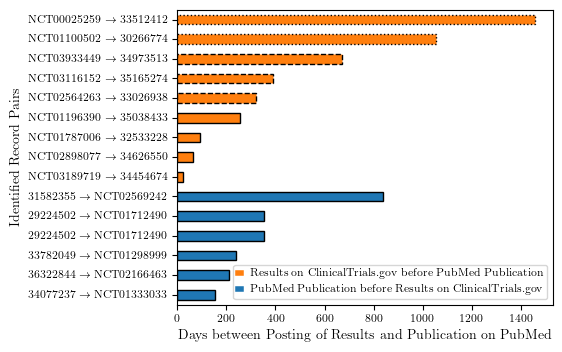

In [37]:
from evaluation.plotting import draw_time_lag_analysis

draw_time_lag_analysis(
    df_time_lag=df_time_lag, output_dir=PATH_LATEX_PLOT_OUTPUT, file_name="time_lag.pdf"
)

### Retrieved vs. Screened

In [38]:
SR_TF_END = {"EC": "03/04/2022", "HL (Retro.)": "03/14/2019", "HL": "06/01/2023"}

In [39]:
df_query_pm = df_query.query("(source == 'Pubmed') & (is_rct_pt == True)").copy()

In [40]:
df_query_pm["days_to_publication"] = df_query_pm.apply(
    lambda row: row["publication_date_combined"]
    - pd.to_datetime(SR_TF_END[row.name[0]]),
    axis=1,
)

In [41]:
df_query_pm["days_to_publication"].min()

Timedelta('-2696 days +00:00:00')

In [42]:
df_query_pm["days_to_publication"].max()

Timedelta('216 days 00:00:00')

In [43]:
bin_borders = [-3000, -2000, -1000, -500, -300, -200, -100, -50, 300]

In [44]:
bins = pd.cut(df_query_pm["days_to_publication"].dt.days, bins=bin_borders, right=False)

In [65]:
n_screened = df_query_pm.groupby(bins)["is_screened"].sum()
n_published = df_query_pm.groupby(bins).size()

In [71]:
n_published.sum()

356

In [72]:
n_screened.sum()

240

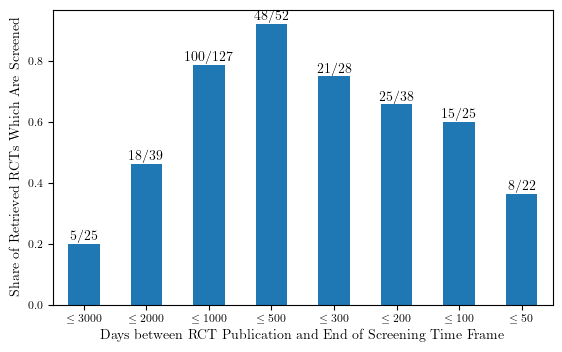

In [70]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"), layout="constrained")

df_query_pm.groupby(bins).apply(lambda g: g["is_screened"].sum() / g.shape[0]).plot(
    kind="bar",
    ax=ax,
    ylabel="Share of Retrieved RCTs Which Are Screened",
    xlabel="Days between RCT Publication and End of Screening Time Frame",
    rot=0,
)

ax.set_xticklabels([f"$\leq{abs(i)}$" for i in bin_borders[:-1]])

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    labels=[
        f"{scr}/{pub}" for scr, pub in zip(n_screened.to_list(), n_published.to_list())
    ],
)

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(
        PATH_LATEX_PLOT_OUTPUT / "days_between_publication_end_of_screening.pdf"
    )